# MS-AAI-501: Intro to AI
## Final Project:  Airline Flight Delay Analysis and Modeling
### File Name:  XGBoos Model.jpynb
### Date:  12/4/2023
### Author:  Ned Kost


In [1]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.metrics import accuracy_score

In [2]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()

# Reducing dimensionality of TimeZones 
def binary_encode(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

def calculate_crsDeptTime(dept, delay):
    s = str(int(dept))
    if(len(s) < 3):
        t =  dt.timedelta(hours=0, minutes=int(dept))
    if(len(s) == 3):
        t =  dt.timedelta(hours=int(s[0]), minutes=int(s[-2:]))
    if(len(s) > 3):
        t =  dt.timedelta(hours=int(s[:2]), minutes=int(s[-2:]))
    delta = (t - dt.timedelta(minutes=int(delay)))
    result = days_hours_minutes(delta)
    return(float(str(result[1]) + (str(result[2]))))


# Data Loading and Preprocessing

In [3]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# Calculate CRSDepTime as Actual Departure Time minus Departure Delay
flights_df['CRSDepTime'] = flights_df.apply(lambda x: calculate_crsDeptTime(x['DepTime'], x['DepDelay']), axis=1)

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,...,Origin_Precip,Dest_Windspeed,Dest_Precip,dest_ianaTimeZone,origin_ianaTimeZone,Aircraft_Daily_Flight_Count,FlightDateDT,DepTarmacTime,ArrTarmacTime,CRSDepTime
0,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N407AN,664.0,KOA,...,0.08,0.0,0.0,America/Phoenix,America/Los_Angeles,1,2020-01-01,900.0,360.0,2355.0
1,2020.0,1.0,1.0,1.0,3.0,2020-01-01,9E,N297PQ,5270.0,LFT,...,0.00,5.0,0.0,America/New_York,America/Chicago,1,2020-01-01,900.0,420.0,60.0
2,2020.0,1.0,1.0,1.0,3.0,2020-01-01,WN,N963WN,1395.0,CMH,...,0.00,7.0,0.0,America/Chicago,America/New_York,1,2020-01-01,540.0,300.0,555.0
3,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N891NN,137.0,TUS,...,0.00,8.0,0.0,America/Chicago,America/Phoenix,1,2020-01-01,1200.0,840.0,60.0
4,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N807AW,2189.0,SAT,...,0.00,12.0,0.0,America/Chicago,America/Chicago,1,2020-01-01,660.0,960.0,610.0


# XGBoost with Feature sets 1, 2, & 3

In [5]:
# Build function to initialize, test, and train model
#   INPUT:  df = dataframe to use with the model
#   INPUT:  features = feature list to use with the mdoel
#   OUTPUT:  XGBoost Model trained and tested
def run_boost_model(df, features):
    # Declare X and Y from dataframe
    x = df[features]
    y = df['Delayed']

    # Encoding categorical variables
    if  'origin_ianaTimeZone' in features:
        x = binary_encode(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
        x = pd.get_dummies(x, columns=['Carrier'])
    else:
        x = binary_encode(x, ['Dest', 'Origin'])
        x = pd.get_dummies(x, columns=['Carrier'])

    # Create a Test Train split of data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

    # Initialize XGBClassifier, and train it with training datasets
    gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1, random_state=42)
    gb_model.fit(x_train,y_train)

    # Predict Values and Probabilities from the test data
    gb_predict = gb_model.predict(x_test)
    gb_prob = gb_model.predict_proba(x_test)

    # Calculate Accuracy scores (AUC, Accuracy, F1, Log Loss) of model
    auc = roc_auc_score(y_test, gb_prob[:,1])
    acc = accuracy_score(y_test, gb_predict)
    f1 = f1_score(y_test, gb_predict)
    loss = log_loss(y_test, gb_predict)

    # Print Metrics and Summary
    print('(AUC) XGBoost Prob: %.4f' % auc)
    print('Accuracy Score: %.4f' % acc)
    print('F1 Score: %.4f' % f1)
    print('Log Loss: %.4f' % loss)
    
    return gb_model

In [7]:
# Columns to use as Features (Pulling from Feature Sets 1, 2, and 3)
fs123 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime', 'AirTime', 'ArrTarmacTime']

# Create Model using Features from Feature Sets 1, 2, and 3
fs123_model = run_boost_model(flights_df, fs123)
print('')
print('Using Feature Set 1, 2, and 3 this model can get an AUC score of .9994 which is extremely good!')
print('However, since this model uses information about Arrival, it may not be useful for a business case.')

(AUC) XGBoost Prob: 0.9994
Accuracy Score: 0.9884
F1 Score: 0.9885
Log Loss: 0.4181

Using Feature Set 1, 2, and 3 this model can get an AUC score of .9994 which is extremely good!
However, since this model uses information about Arrival, it may not be useful for a business case.


# XGBoost with Feature Sets 1 & 2

In [8]:
# Columns to use as Features (Pulling from Feature Sets 1 and 2)
fs12 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime']

# Create Model using Features from Feature Sets 1 and 2
fs12_model = run_boost_model(flights_df, fs12)

print('')
print('With a reduced feature set that excludes Arrival information, we are able to get an AUC score of .9683.')
print('This is still a great score, and could be useful for determining the likilhood that a flight will be delayed up to the point of departure.')


(AUC) XGBoost Prob: 0.9683
Accuracy Score: 0.9135
F1 Score: 0.9111
Log Loss: 3.1165

With a reduced feature set that excludes Arrival information, we are able to get an AUC score of .9683.
This is still a great score, and could be useful for determining the likilhood that a flight will be delayed up to the point of departure.


In [9]:
# Feature Set 1 & 2 minus weather data and timezones
fs12_minus = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 
            'DepDelay','DepTarmacTime']

# Create Model using Features from Feature Sets 1 and 2 minus weather and timezone
fs12_minus_model = run_boost_model(flights_df, fs12_minus)


(AUC) XGBoost Prob: 0.9654
Accuracy Score: 0.9106
F1 Score: 0.9078
Log Loss: 3.2216


# XGBoost With Feature Set 1 only

In [10]:
# Columns to use as Features (Pulling from Feature Sets 1 and 2)
fs1 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Carrier', 
            'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time',
            'Origin_Windspeed','Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone']

# Create Model using Features from Feature Set 1 only
fs1_model = run_boost_model(flights_df, fs1)

#Output Analysis
print('')
print('Removing the Feature Set 2 data, we get an AUC of .6919.  This is not great and is unlikely to be very useful.')
print('It may be helpful for determining potential probabilities that the flight could be delayed using the probabilities output from the model, though it will take some domain knowledge to make a definitive decision.')


(AUC) XGBoost Prob: 0.6919
Accuracy Score: 0.6398
F1 Score: 0.6334
Log Loss: 12.9813

Removing the Feature Set 2 data, we get an AUC of .6919.  This is not great and is unlikely to be very useful.
It may be helpful for determining potential probabilities that the flight could be delayed using the probabilities output from the model, though it will take some domain knowledge to make a definitive decision.


In [11]:
# Columns to use as Features (Pulling from Feature Sets 1 and 2) Minus weather and timezone
fs1_minus = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Carrier', 
            'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time']

# Create Model using Features from Feature Set 1 only
fs1_modified_model = run_boost_model(flights_df, fs1_minus)

(AUC) XGBoost Prob: 0.6752
Accuracy Score: 0.6275
F1 Score: 0.6233
Log Loss: 13.4275


# Testing with 2023 Data

In [30]:
def run_mode_with_test_data(df, features, gb_model):
    # Declare x and y using test dataset
    x = df[features]
    y = df['Delayed']

    # Encode Dest, Origin, and Carreir
    x = binary_encode(x, ['Dest', 'Origin'])
    x = pd.get_dummies(x, columns=['Carrier'])

    # Add carrier missing from Test Dataset and reorder to match model
    x['Carrier_QX'] = 0
    x['Carrier_YV'] = 0
    cols = ['Month', 'DayOfWeek', 'DayofMonth', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Distance',
            'Aircraft_Daily_Flight_Count','Full-time','Part-time', 'DepDelay','DepTarmacTime',
            'Dest_0', 'Dest_1', 'Dest_2', 'Dest_3','Dest_4', 'Dest_5', 'Dest_6', 'Dest_7', 'Dest_8',
            'Origin_0','Origin_1', 'Origin_2', 'Origin_3', 'Origin_4', 'Origin_5', 'Origin_6','Origin_7', 'Origin_8',
            'Carrier_9E', 'Carrier_AA', 'Carrier_AS','Carrier_B6', 'Carrier_DL', 'Carrier_F9', 'Carrier_G4',
            'Carrier_HA','Carrier_MQ', 'Carrier_NK', 'Carrier_OH', 'Carrier_OO', 'Carrier_QX','Carrier_UA',
            'Carrier_WN', 'Carrier_YV', 'Carrier_YX']
    x = x[cols]

    print(x.columns)
    
    # Predict Values and Probabilities from the test data
    gb_predict = gb_model.predict(x)
    gb_prob = gb_model.predict_proba(x)

    # Calculate Accuracy scores (AUC, Accuracy, F1, Log Loss) of model
    auc = roc_auc_score(y, gb_prob[:,1])
    acc = accuracy_score(y, gb_predict)
    f1 = f1_score(y, gb_predict)
    loss = log_loss(y, gb_predict)

    # Print Metrics and Summary
    print('(AUC) XGBoost Prob: %.4f' % auc)
    print('Accuracy Score: %.4f' % acc)
    print('F1 Score: %.4f' % f1)
    print('Log Loss: %.4f' % loss)
    

In [13]:
# Load Test dataset (2023 Flight data)
test_df =  pd.read_csv('../data/flight_test_data.csv')

# Convert Flight Date to a Date Timestamp
test_df['FlightDateDT'] = pd.to_datetime(test_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
test_df['DepTarmacTime'] = test_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate Aircraft_Daily_Flight_Count
tailnum_df = pd.DataFrame(test_df.groupby(['Tail_Number', 'FlightDate'])['Tail_Number'].count())
tailnum_df.rename(columns={'Tail_Number': 'Count'}, inplace=True)
tailnum_df = tailnum_df.reset_index()
test_df = pd.merge(test_df, tailnum_df, how='left', on=['FlightDate', 'Tail_Number'])

# Rename ArrDel15 to Delayed - This is the column being predicted
test_df.rename(columns={'ArrDel15':'Delayed', 'Reporting_Airline':'Carrier', 'Count': 'Aircraft_Daily_Flight_Count'}, inplace=True)

cols = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'DepDelay','DepTarmacTime', 'Delayed']
test_df = test_df[cols]
test_df.head()

,Month,DayOfWeek,DayofMonth,Origin,Dest,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Carrier,Aircraft_Daily_Flight_Count,Full-time,Part-time,DepDelay,DepTarmacTime,Delayed
0,1,3,11,ATL,BUF,2240,38,118.0,712.0,DL,1,94236,439,105.0,660.0,1.0
1,1,7,22,DEN,MKE,2105,20,135.0,896.0,WN,1,66965,1523,41.0,600.0,1.0
2,1,7,22,BOS,IND,1610,1914,184.0,818.0,YX,1,5719,231,-5.0,3840.0,1.0
3,1,3,11,EWR,ATL,1400,1627,147.0,746.0,DL,1,94236,439,1043.0,1140.0,1.0
4,1,1,23,FLL,ATL,1900,2100,120.0,581.0,WN,1,66965,1523,8.0,1620.0,1.0


In [14]:
# Declare features to use from Test Dataset
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Carrier', 
            'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time']

# Predict Test data using FS1 Model
run_mode_with_test_data(test_df, features, fs1_modified_model)

(AUC) XGBoost Prob: 0.6305
Accuracy Score: 0.5943
F1 Score: 0.5948
Log Loss: 14.6229


In [32]:
fs12_test = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'DepDelay',
           'DepTarmacTime', 'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time']

# Predict Test data usng FS1 and 2 Model
run_mode_with_test_data(test_df, fs12_test, fs12_minus_model)


Index(['Month', 'DayOfWeek', 'DayofMonth', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Aircraft_Daily_Flight_Count',
       'Full-time', 'Part-time', 'DepDelay', 'DepTarmacTime', 'Dest_0',
       'Dest_1', 'Dest_2', 'Dest_3', 'Dest_4', 'Dest_5', 'Dest_6', 'Dest_7',
       'Dest_8', 'Origin_0', 'Origin_1', 'Origin_2', 'Origin_3', 'Origin_4',
       'Origin_5', 'Origin_6', 'Origin_7', 'Origin_8', 'Carrier_9E',
       'Carrier_AA', 'Carrier_AS', 'Carrier_B6', 'Carrier_DL', 'Carrier_F9',
       'Carrier_G4', 'Carrier_HA', 'Carrier_MQ', 'Carrier_NK', 'Carrier_OH',
       'Carrier_OO', 'Carrier_QX', 'Carrier_UA', 'Carrier_WN', 'Carrier_YV',
       'Carrier_YX'],
      dtype='object')
(AUC) XGBoost Prob: 0.9591
Accuracy Score: 0.9021
F1 Score: 0.9004
Log Loss: 3.5282


# Parameter Tuning

The below HyperParameter tuning using StratifiedKFold and GridSearch was performed with the Initial Logisitc Regression Model using Featue Sets 1, 2, and 3.  Once ideal parameters were identified, all models were updated with the same parameters.

Best: -0.637375 using {'learning_rate': 0.2, 'n_estimators': 200}
-0.692742 (0.000017) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.692344 (0.000034) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.689424 (0.000147) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.686289 (0.000259) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.670683 (0.000674) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.662612 (0.000966) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.645503 (0.001461) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.639900 (0.001598) with: {'learning_rate': 0.1, 'n_estimators': 200}
-0.640621 (0.001429) with: {'learning_rate': 0.2, 'n_estimators': 100}
-0.637375 (0.001491) with: {'learning_rate': 0.2, 'n_estimators': 200}
-0.639527 (0.001667) with: {'learning_rate': 0.3, 'n_estimators': 100}
-0.638880 (0.001816) with: {'learning_rate': 0.3, 'n_estimators': 200}


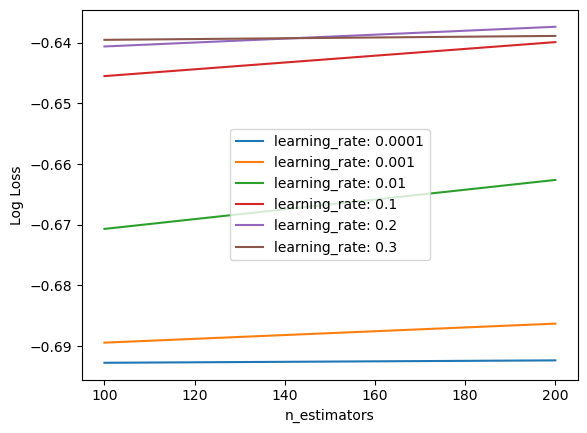

In [138]:
# Tune Nodes and Learning Rate to find best combination
n_estimators = [100, 200]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

Based on the above chart, the learning rates that look most promising are .1 and .2.  Each of these have an upward trajectory with the lowest log loss.

Best: -0.634748 using {'learning_rate': 0.1, 'n_estimators': 800}
-0.634819 (0.001925) with: {'learning_rate': 0.1, 'n_estimators': 600}
-0.634777 (0.002000) with: {'learning_rate': 0.1, 'n_estimators': 700}
-0.634748 (0.002042) with: {'learning_rate': 0.1, 'n_estimators': 800}
-0.634886 (0.002063) with: {'learning_rate': 0.1, 'n_estimators': 900}
-0.635045 (0.002086) with: {'learning_rate': 0.1, 'n_estimators': 1000}
-0.638520 (0.002033) with: {'learning_rate': 0.2, 'n_estimators': 600}
-0.639708 (0.002076) with: {'learning_rate': 0.2, 'n_estimators': 700}
-0.640774 (0.002265) with: {'learning_rate': 0.2, 'n_estimators': 800}
-0.642156 (0.002614) with: {'learning_rate': 0.2, 'n_estimators': 900}
-0.643527 (0.002917) with: {'learning_rate': 0.2, 'n_estimators': 1000}


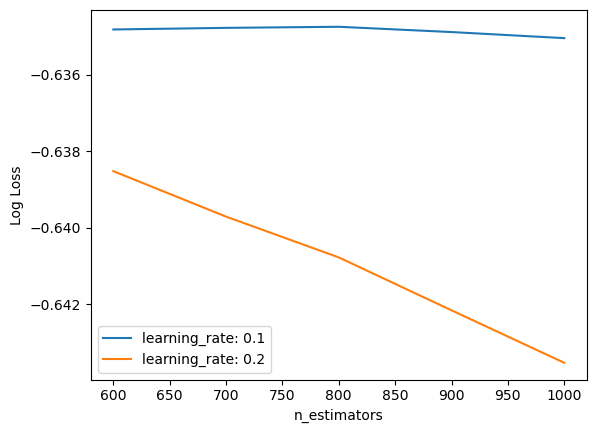

In [140]:
# Fine tune Learning Rate and Nodes for best combination
n_estimators = [600, 700, 800, 900, 1000]
learning_rate = [0.1, 0.2]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
# Further tuning
# max_depth
# (sample_rate and col_sample_rate) 

# Gradient Boost Model on Full 3-Year Data Set

In [33]:
# Load larger dataset
all_flights_df = pd.read_csv('../data/flight_data_large_balanced.csv')

# Drop columns that are missing data
all_flights_df = all_flights_df.dropna()

# Rename ArrDel15 to Delayed - This is the column being predicted
all_flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

# Filter dataset to columns to use for this experiment with the larger dataset
cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Dest', 'Origin', 'Distance', 'Carrier',
        'Full-time', 'Part-time', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Delayed']
all_flights_df = all_flights_df[cols]


all_flights_df.head()


,Month,DayofMonth,DayOfWeek,Dest,Origin,Distance,Carrier,Full-time,Part-time,CRSDepTime,CRSArrTime,CRSElapsedTime,Delayed
0,1,1,3,ORD,FAT,1730.0,UA,80145.0,11892.0,-54.0,507,241.0,1.0
1,1,1,3,PHX,KOA,2860.0,AA,95612.0,11840.0,-5.0,833,338.0,1.0
2,1,1,3,RDU,DEN,1436.0,F9,4957.0,63.0,5.0,527,202.0,0.0
3,1,1,3,MKE,ATL,669.0,DL,80582.0,10245.0,-85.0,2340,125.0,1.0
4,1,1,3,LBB,DFW,282.0,YV,3512.0,14.0,-85.0,2345,70.0,1.0


In [34]:
features = ['Month', 'DayofMonth', 'DayOfWeek', 'Dest', 'Origin', 'Distance', 'Carrier', 
            'Full-time', 'Part-time', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']

# Create Model using Features from Feature Sets 1 without weather
full_model = run_boost_model(all_flights_df, features)


(AUC) XGBoost Prob: 0.7380
Accuracy Score: 0.6931
F1 Score: 0.5471
Log Loss: 11.0621
